In [1]:
import numpy as np
import pandas as pd
from sklearn.manifold import MDS, TSNE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from geopy.distance import geodesic
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium
from gensim.models import Word2Vec
import os
import dash
from dash import dcc, html, Input, Output, callback_context
from itertools import combinations
import re

In [2]:
# ÂÆöÁæ©Ëº∏Âá∫Ë≥áÊñôÂ§æË∑ØÂæë
OUTPUT_DIR = 'C:/Users/user/Desktop/ML_Work4/outputs'
DATA_DIR = 'C:/Users/user/Desktop/ML_Work4/data'

# ÂâµÂª∫Ëº∏Âá∫Ë≥áÊñôÂ§æ
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# ÂâµÂª∫Ë≥áÊñôË≥áÊñôÂ§æ
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)


In [3]:
def process_train_stations():
    """ËôïÁêÜÁÅ´ËªäÁ´ôË≥áÊñôÈõÜÔºå‰ΩøÁî®MDSÈÄ≤Ë°åË¶ñË¶∫Âåñ"""
    stations = {
        'Âè∞Âåó': (25.0477, 121.5174),
        'Êñ∞Á´π': (24.8021, 120.9715),
        'Âè∞‰∏≠': (24.1376, 120.6870),
        'ÊñóÂÖ≠': (23.7121, 120.5410),
        'ÁéâÈáå': (23.3321, 121.3117),
        'Áü•Êú¨': (22.7103, 121.0606),
        'È´òÈõÑ': (22.6398, 120.3028),
    }
    
    # Ë®àÁÆóË∑ùÈõ¢Áü©Èô£
    station_names = list(stations.keys())
    n = len(stations)
    dist_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i != j:
                dist_matrix[i, j] = geodesic(stations[station_names[i]], stations[station_names[j]]).km
    
    # ÊáâÁî® MDS
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    mds_coords = mds.fit_transform(dist_matrix)
    
    # ‰øùÂ≠òÁµêÊûú
    fig = px.scatter(x=mds_coords[:, 0], y=mds_coords[:, 1], text=station_names, 
                     title='MDSÔºöÂè∞ÁÅ£ÁÅ´ËªäÁ´ôÁõ∏Â∞ç‰ΩçÁΩÆ')
    fig.update_traces(textposition='top center', marker=dict(size=10))
    fig.update_layout(xaxis_title='MDS Á∂≠Â∫¶ 1', yaxis_title='MDS Á∂≠Â∫¶ 2')
    fig.write_image(file=os.path.join(OUTPUT_DIR, 'mds_train_stations.png'), format='png')
    
    # Âª∫Á´ãÂú∞Âúñ
    create_google_map(stations)
    
    return mds_coords, station_names

In [4]:
def create_google_map(stations):
    """ÂâµÂª∫ÂåÖÂê´ÁÅ´ËªäÁ´ôÊ®ôË®òÁöÑÂú∞Âúñ"""
    center_lat = sum([coord[0] for coord in stations.values()]) / len(stations)
    center_lon = sum([coord[1] for coord in stations.values()]) / len(stations)
    
    m = folium.Map(location=[center_lat, center_lon], zoom_start=7)
    
    for name, (lat, lon) in stations.items():
        folium.Marker(
            location=[lat, lon],
            popup=f'{name}ÁÅ´ËªäÁ´ô',
            tooltip=name,
            icon=folium.Icon(color='red', icon='train', prefix='fa')
        ).add_to(m)
    
    m.save(os.path.join(OUTPUT_DIR, 'train_stations_map.html'))
    return m

In [5]:
def load_drink_dataset():
    """ËÆÄÂèñÈ£≤ÊñôË≥áÊñôÈõÜ"""
    file_path = r'C:\Users\user\Desktop\ML_Work4\data\drinkset.xlsx'
    
    try:
        df = pd.read_excel(file_path)
        print("È£≤ÊñôË≥áÊñôÈõÜËºâÂÖ•ÊàêÂäüÔºÅ")
        print(f"Ë≥áÊñôÂΩ¢ÁãÄÔºö{df.shape}")
        print("Ê¨Ñ‰ΩçÂêçÁ®±Ôºö", df.columns.tolist())
        
        # Ê®ôÊ∫ñÂåñÊ¨Ñ‰ΩçÂêçÁ®±
        column_mapping = {}
        for col in df.columns:
            col_lower = col.lower()
            if col_lower in ['class', 'È°ûÂà•']:
                column_mapping[col] = 'Class'
            elif col_lower in ['drink', 'È£≤Êñô']:
                column_mapping[col] = 'Drink'
            elif col_lower in ['rank', 'ÊéíÂêç']:
                column_mapping[col] = 'Rank'
            elif col_lower in ['amount', 'ÈáëÈ°ç']:
                column_mapping[col] = 'Amount'
            elif col_lower in ['quantity', 'Êï∏Èáè']:
                column_mapping[col] = 'Quantity'
            elif col_lower in ['count', 'Ë®àÊï∏']:
                column_mapping[col] = 'Count'
        
        df = df.rename(columns=column_mapping)
        return df
        
    except FileNotFoundError:
        print(f"ÈåØË™§ÔºöÊâæ‰∏çÂà∞Ê™îÊ°à {file_path}")
        return None
    except Exception as e:
        print(f"ËÆÄÂèñÊ™îÊ°àÊôÇÁôºÁîüÈåØË™§Ôºö{e}")
        return None

In [6]:
def expand_drink_data(df):
    """Â±ïÈñãÈ£≤ÊñôË≥áÊñôÔºàËôïÁêÜCountÊ¨Ñ‰ΩçÔºâ"""
    if 'Count' not in df.columns:
        return df.copy()
    
    print("Â±ïÈñãË≥áÊñô...")
    expanded_data = []
    np.random.seed(42)
    
    for _, row in df.iterrows():
        count = int(row['Count'])
        for _ in range(count):
            # ËôïÁêÜAmountÊ¨Ñ‰Ωç
            amount_str = str(row['Amount'])
            if '(' in amount_str and ')' in amount_str:
                amount_clean = amount_str.strip('()').replace(' ', '')
                try:
                    mean, std = map(float, amount_clean.split(','))
                    amount_value = np.random.normal(mean, std)
                except:
                    amount_value = 100
            else:
                try:
                    amount_value = float(amount_str)
                except:
                    amount_value = 100
            
            # ËôïÁêÜQuantityÊ¨Ñ‰Ωç
            quantity_str = str(row['Quantity'])
            if 'Random' in quantity_str or 'random' in quantity_str:
                numbers = re.findall(r'\d+', quantity_str)
                if len(numbers) >= 2:
                    min_qty, max_qty = int(numbers[0]), int(numbers[1])
                    qty_value = np.random.randint(min_qty, max_qty + 1)
                else:
                    qty_value = 500
            else:
                try:
                    qty_value = float(quantity_str)
                except:
                    qty_value = 500
            
            expanded_data.append([
                row['Class'], row['Drink'], row['Rank'], amount_value, qty_value
            ])
    
    expanded_df = pd.DataFrame(expanded_data, 
                             columns=['Class', 'Drink', 'Rank', 'Amount', 'Quantity'])
    print(f"Ë≥áÊñôÂ±ïÈñãÂÆåÊàêÔºöÂæû {len(df)} Ë°åÂ±ïÈñãÁÇ∫ {len(expanded_df)} Ë°å")
    return expanded_df

In [7]:
def compute_manual_dissimilarity_matrix(drinks, same_category_diss, cross_category_diss):
    """Ë®àÁÆóÊâãÂãïË®≠ÂÆöÁöÑ‰∏çÁõ∏‰ººÂ∫¶Áü©Èô£"""
    drink_groups = [
        ['Coke', 'Pepsi', 'Sprite', '7Up'],
        ['Cappuccino', 'Espresso', 'Latte', 'Mocha'],
    ]
    
    # Âª∫Á´ã‰∏çÁõ∏‰ººÂ∫¶Â≠óÂÖ∏
    dissimilarity = {}
    for group in drink_groups:
        for pair in combinations(group, 2):
            sorted_pair = tuple(sorted(pair))
            dissimilarity[sorted_pair] = same_category_diss
    
    # Âª∫Á´ãË∑ùÈõ¢Áü©Èô£
    n = len(drinks)
    dist_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i != j:
                pair = tuple(sorted([drinks[i], drinks[j]]))
                dist_matrix[i, j] = dissimilarity.get(pair, cross_category_diss)
    
    return dist_matrix

In [1]:
def compute_word2vec_dissimilarity_matrix(df):
    """Ë®àÁÆóWord2Vec‰∏çÁõ∏‰ººÂ∫¶Áü©Èô£"""
    unique_drinks = df['Drink'].unique()
    
    # Ê∫ñÂÇôË®ìÁ∑¥Ë≥áÊñô
    sentences = []
    for drink in unique_drinks:
        if any(beverage in drink.lower() for beverage in ['coke', 'pepsi', 'sprite', '7up']):
            sentence = ['Carbonated', 'bubble', 'Cool', drink]
        else:
            sentence = ['coffee', 'Hot', 'caffeine', drink]
        sentences.append(sentence)
    
    # Ë®ìÁ∑¥Word2VecÊ®°Âûã
    model = Word2Vec(sentences, vector_size=1, window=1, min_count=1, workers=1, seed=42)
    
    # Ë®àÁÆó‰∏çÁõ∏‰ººÂ∫¶Áü©Èô£
    n = len(unique_drinks)
    dist_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i != j:
                try:
                    similarity = model.wv.similarity(unique_drinks[i], unique_drinks[j])
                    dist_matrix[i, j] = 1 - similarity
                except KeyError:
                    dist_matrix[i, j] = 1.0
    
    return dist_matrix, unique_drinks


In [9]:
def tsne_one_hot(df):
    """‰ΩøÁî®One-hotÁ∑®Á¢ºÁöÑt-SNEÂàÜÊûê"""
    expanded_df = expand_drink_data(df)
    
    # One-hotÁ∑®Á¢º
    encoder = OneHotEncoder(sparse_output=False)
    drink_encoded = encoder.fit_transform(expanded_df[['Drink']])
    
    # Êï∏ÂÄºÁâπÂæµ
    numerical_features = expanded_df[['Rank', 'Amount', 'Quantity']].astype(float)
    features = np.hstack([drink_encoded, numerical_features.values])
    
    # Ê®ôÊ∫ñÂåñ
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # t-SNE
    n_samples = len(expanded_df)
    perplexity = min(50, max(5, n_samples // 4))
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, max_iter=1000)
    tsne_coords = tsne.fit_transform(features_scaled)
    
    # Âª∫Á´ãÁµêÊûúDataFrameÔºåÂä†ÂÖ•Á¥¢Âºï
    plot_df = pd.DataFrame({
        'X': tsne_coords[:, 0],
        'Y': tsne_coords[:, 1],
        'Class': expanded_df['Class'],
        'Drink': expanded_df['Drink'],
        'Rank': expanded_df['Rank'],
        'Amount': expanded_df['Amount'],
        'Quantity': expanded_df['Quantity'],
        'Index': range(len(expanded_df))
    })
    
    # Âª∫Á´ã‰∏¶‰øùÂ≠òÂúñË°®
    fig = px.scatter(plot_df, x='X', y='Y', color='Drink', 
                     title='t-SNEÔºàOne-hotÁ∑®Á¢ºÔºâ',
                     hover_data=['Drink', 'Rank', 'Amount', 'Quantity'])
    fig.update_layout(xaxis_title='t-SNE Á∂≠Â∫¶ 1', yaxis_title='t-SNE Á∂≠Â∫¶ 2')
    
    # ‰øùÂ≠òÁµêÊûú
    print(f"   ‰øùÂ≠òOne-hot t-SNEÂúñÁâáÂà∞: {os.path.join(OUTPUT_DIR, 'tsne_one_hot.png')}")
    fig.write_image(file=os.path.join(OUTPUT_DIR, 'tsne_one_hot.png'), format='png')
    plot_df.to_csv(os.path.join(OUTPUT_DIR, 'tsne_one_hot.csv'), index=False)
    print(f"   ‰øùÂ≠òOne-hot t-SNEË≥áÊñôÂà∞: {os.path.join(OUTPUT_DIR, 'tsne_one_hot.csv')}")
    
    return plot_df

In [10]:
def tsne_manual_combination(df, same_diss, cross_diss):
    """ÊâãÂãï‰∏çÁõ∏‰ººÂ∫¶ÁµÑÂêàÁöÑt-SNEÂàÜÊûê"""
    expanded_df = expand_drink_data(df)
    unique_drinks = expanded_df['Drink'].unique()
    drink_to_idx = {drink: idx for idx, drink in enumerate(unique_drinks)}
    
    # Êï∏ÂÄºÁâπÂæµÊ®ôÊ∫ñÂåñ
    numerical_features = StandardScaler().fit_transform(
        expanded_df[['Rank', 'Amount', 'Quantity']].astype(float)
    )
    
    # Ë®àÁÆó‰∏çÁõ∏‰ººÂ∫¶Áü©Èô£
    dist_matrix = compute_manual_dissimilarity_matrix(unique_drinks, same_diss, cross_diss)
    
    # ÁµêÂêà‰∏çÁõ∏‰ººÂ∫¶ËàáÊï∏ÂÄºÁâπÂæµ
    n = len(expanded_df)
    combined_dist = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i != j:
                numerical_dist = np.sqrt(np.sum((numerical_features[i] - numerical_features[j])**2))
                drink_i_idx = drink_to_idx[expanded_df.iloc[i]['Drink']]
                drink_j_idx = drink_to_idx[expanded_df.iloc[j]['Drink']]
                drink_dissim = dist_matrix[drink_i_idx, drink_j_idx]
                combined_dist[i, j] = drink_dissim + numerical_dist
    
    # t-SNE
    n_samples = len(expanded_df)
    perplexity = min(50, max(5, n_samples // 4))
    
    tsne = TSNE(n_components=2, metric='precomputed', init='random', 
                random_state=42, perplexity=perplexity)
    tsne_coords = tsne.fit_transform(combined_dist)
    
    # Âª∫Á´ãÁµêÊûúDataFrame
    plot_df = pd.DataFrame({
        'X': tsne_coords[:, 0],
        'Y': tsne_coords[:, 1],
        'Class': expanded_df['Class'],
        'Drink': expanded_df['Drink'],
        'Rank': expanded_df['Rank'],
        'Amount': expanded_df['Amount'],
        'Quantity': expanded_df['Quantity'],
        'Index': range(len(expanded_df))
    })
    
    return plot_df


In [11]:
def tsne_word2vec(df):
    """‰ΩøÁî®Word2Vec‰∏çÁõ∏‰ººÂ∫¶ÁöÑt-SNEÂàÜÊûê"""
    expanded_df = expand_drink_data(df)
    
    # Ë®àÁÆóWord2Vec‰∏çÁõ∏‰ººÂ∫¶
    dist_matrix, unique_drinks = compute_word2vec_dissimilarity_matrix(expanded_df)
    drink_to_idx = {drink: idx for idx, drink in enumerate(unique_drinks)}
    
    # Êï∏ÂÄºÁâπÂæµÊ®ôÊ∫ñÂåñ
    numerical_features = StandardScaler().fit_transform(
        expanded_df[['Rank', 'Amount', 'Quantity']].astype(float)
    )
    
    # ÁµêÂêà‰∏çÁõ∏‰ººÂ∫¶ËàáÊï∏ÂÄºÁâπÂæµ
    n = len(expanded_df)
    combined_dist = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i != j:
                numerical_dist = np.sqrt(np.sum((numerical_features[i] - numerical_features[j])**2))
                drink_i_idx = drink_to_idx[expanded_df.iloc[i]['Drink']]
                drink_j_idx = drink_to_idx[expanded_df.iloc[j]['Drink']]
                drink_dissim = dist_matrix[drink_i_idx, drink_j_idx]
                combined_dist[i, j] = drink_dissim + numerical_dist
    
    # t-SNE
    n_samples = len(expanded_df)
    perplexity = min(50, max(5, n_samples // 4))
    
    tsne = TSNE(n_components=2, metric='precomputed', init='random', 
                random_state=42, perplexity=perplexity)
    tsne_coords = tsne.fit_transform(combined_dist)
    
    # Âª∫Á´ãÁµêÊûúDataFrame
    plot_df = pd.DataFrame({
        'X': tsne_coords[:, 0],
        'Y': tsne_coords[:, 1],
        'Class': expanded_df['Class'],
        'Drink': expanded_df['Drink'],
        'Rank': expanded_df['Rank'],
        'Amount': expanded_df['Amount'],
        'Quantity': expanded_df['Quantity'],
        'Index': range(len(expanded_df))
    })
    
    # Âª∫Á´ã‰∏¶‰øùÂ≠òÂúñË°®
    fig = px.scatter(plot_df, x='X', y='Y', color='Drink', 
                     title='t-SNEÔºàWord2Vec‰∏çÁõ∏‰ººÂ∫¶Ôºâ',
                     hover_data=['Drink', 'Rank', 'Amount', 'Quantity'])
    fig.update_layout(xaxis_title='t-SNE Á∂≠Â∫¶ 1', yaxis_title='t-SNE Á∂≠Â∫¶ 2')
    
    # ‰øùÂ≠òÁµêÊûú
    print(f"   ‰øùÂ≠òWord2Vec t-SNEÂúñÁâáÂà∞: {os.path.join(OUTPUT_DIR, 'tsne_word2vec.png')}")
    fig.write_image(file=os.path.join(OUTPUT_DIR, 'tsne_word2vec.png'), format='png')
    plot_df.to_csv(os.path.join(OUTPUT_DIR, 'tsne_word2vec.csv'), index=False)
    print(f"   ‰øùÂ≠òWord2Vec t-SNEË≥áÊñôÂà∞: {os.path.join(OUTPUT_DIR, 'tsne_word2vec.csv')}")
    
    return plot_df

In [12]:
def create_interactive_mds_plot(mds_coords, station_names):
    """Âª∫Á´ãÁÅ´ËªäÁ´ôMDS‰∫íÂãïÂúñË°®"""
    mds_df = pd.DataFrame({
        'X': mds_coords[:, 0],
        'Y': mds_coords[:, 1],
        'Station': station_names,
        'Type': 'ÁÅ´ËªäÁ´ô',
        'Index': range(len(station_names))
    })
    
    fig = px.scatter(
        mds_df, x='X', y='Y', 
        text='Station',
        title='MDSÔºöÂè∞ÁÅ£ÁÅ´ËªäÁ´ôÁõ∏Â∞ç‰ΩçÁΩÆ',
        hover_data=['Station']
    )
    
    fig.update_traces(
        textposition='top center', 
        marker=dict(size=12, color='darkorange'),
        textfont=dict(size=10)
    )
    
    fig.update_layout(
        xaxis_title='MDS Á∂≠Â∫¶ 1',
        yaxis_title='MDS Á∂≠Â∫¶ 2',
        dragmode='select',
        selectdirection='d',
        hovermode='closest',
        height=500
    )
    
    return fig, mds_df

In [13]:
def create_interactive_tsne_plot(data_df, title, method_type=""):
    """Âª∫Á´ãt-SNE‰∫íÂãïÂúñË°®"""
    fig = px.scatter(
        data_df, x='X', y='Y', 
        color='Drink',
        title=title,
        hover_data=['Drink', 'Class', 'Rank', 'Amount', 'Quantity']
    )
    
    fig.update_layout(
        xaxis_title='t-SNE Á∂≠Â∫¶ 1',
        yaxis_title='t-SNE Á∂≠Â∫¶ 2',
        dragmode='select',
        selectdirection='d',
        hovermode='closest',
        height=500
    )
    
    return fig


In [14]:
def display_selection_info_single(selected_data, data_df, plot_title):
    """È°ØÁ§∫ÂñÆ‰∏ÄÂúñË°®ÈÅ∏‰∏≠Ë≥áÊñôÁöÑË©≥Á¥∞Ë≥áË®ä"""
    if selected_data is None or 'points' not in selected_data:
        print(f"{plot_title}: Â∞öÊú™ÈÅ∏Êìá‰ªª‰ΩïË≥áÊñôÈªû")
        return
    
    selected_points = selected_data['points']
    if len(selected_points) == 0:
        print(f"{plot_title}: Â∞öÊú™ÈÅ∏Êìá‰ªª‰ΩïË≥áÊñôÈªû")
        return
    
    print(f"\n{plot_title} - ÈÅ∏‰∏≠‰∫Ü {len(selected_points)} ÂÄãË≥áÊñôÈªûÔºö")
    print("="*60)
    
    selected_indices = [point['pointIndex'] for point in selected_points]
    selected_df = data_df.iloc[selected_indices]
    
    # È°ØÁ§∫ÈÅ∏‰∏≠Ë≥áÊñôÁöÑÊëòË¶Å
    if 'Station' in data_df.columns:
        # ÁÅ´ËªäÁ´ôË≥áÊñô
        stations = selected_df['Station'].tolist()
        print(f"ÈÅ∏‰∏≠ÁÅ´ËªäÁ´ô: {', '.join(stations)}")
    else:
        # È£≤ÊñôË≥áÊñô
        drink_counts = selected_df['Drink'].value_counts()
        print(f"È£≤ÊñôÈ°ûÂûãÂàÜÂ∏É:")
        for drink, count in drink_counts.items():
            print(f"   {drink}: {count} Èªû")
        
        print(f"\nÁµ±Ë®àË≥áË®ä:")
        if 'Rank' in selected_df.columns:
            print(f"   ÊéíÂêçÁØÑÂúç: {selected_df['Rank'].min():.1f} - {selected_df['Rank'].max():.1f}")
        if 'Amount' in selected_df.columns:
            print(f"   ÈáëÈ°çÁØÑÂúç: {selected_df['Amount'].min():.1f} - {selected_df['Amount'].max():.1f}")
        if 'Quantity' in selected_df.columns:
            print(f"   Êï∏ÈáèÁØÑÂúç: {selected_df['Quantity'].min():.1f} - {selected_df['Quantity'].max():.1f}")
    
    print("="*60)

ÈñãÂßãÂü∑Ë°åÊ©üÂô®Â≠∏Áøí‰ΩúÊ•≠Âõõ...
ËÆÄÂèñÈ£≤ÊñôË≥áÊñôÈõÜ...
È£≤ÊñôË≥áÊñôÈõÜËºâÂÖ•ÊàêÂäüÔºÅ
Ë≥áÊñôÂΩ¢ÁãÄÔºö(8, 6)
Ê¨Ñ‰ΩçÂêçÁ®±Ôºö ['Class', 'Drink', 'Rank', 'Amount', 'Quantity', 'Count']
È£≤ÊñôË≥áÊñôÈõÜËºâÂÖ•ÂÆåÊàê

ÈñãÂßãÁîüÊàêÊâÄÊúâ‰∫íÂãïÂºèÂúñË°®

1. ÁÅ´ËªäÁ´ôMDSÂúñ...


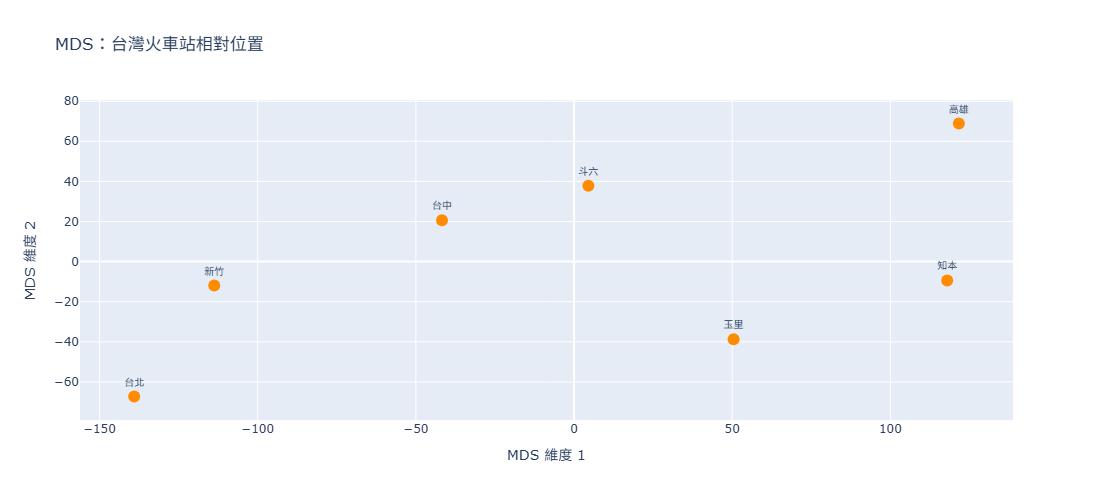

ÁÅ´ËªäÁ´ôMDSÂúñÈ°ØÁ§∫ÂÆåÊàê

 2. t-SNE (One-hotÁ∑®Á¢º)...
Â±ïÈñãË≥áÊñô...
Ë≥áÊñôÂ±ïÈñãÂÆåÊàêÔºöÂæû 8 Ë°åÂ±ïÈñãÁÇ∫ 1600 Ë°å
   ‰øùÂ≠òOne-hot t-SNEÂúñÁâáÂà∞: C:/Users/user/Desktop/ML_Work4/outputs\tsne_one_hot.png
   ‰øùÂ≠òOne-hot t-SNEË≥áÊñôÂà∞: C:/Users/user/Desktop/ML_Work4/outputs\tsne_one_hot.csv


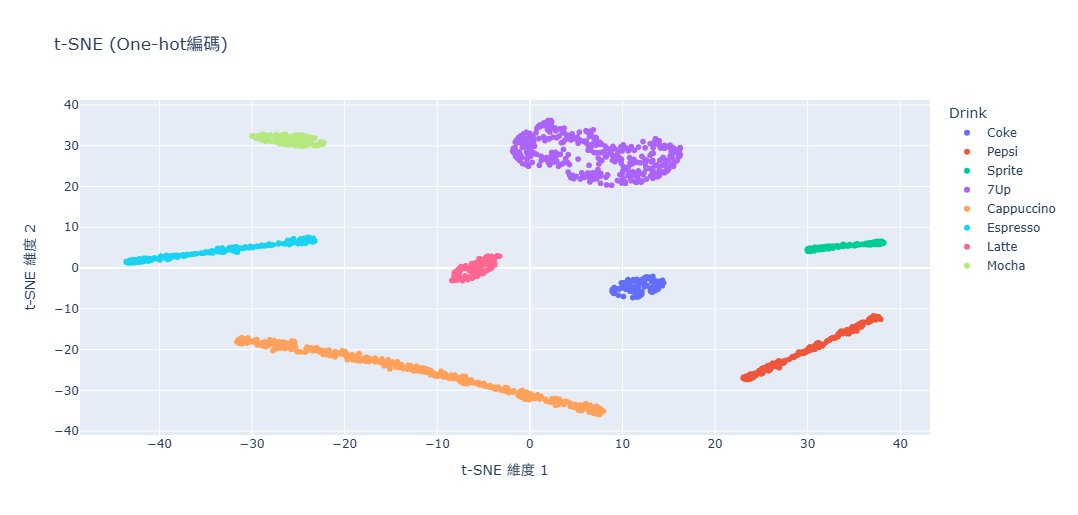

One-hotÁ∑®Á¢ºt-SNEÈ°ØÁ§∫ÂÆåÊàê

‚öôÔ∏è  3. ‰πùÁ®ÆÊâãÂãï‰∏çÁõ∏‰ººÂ∫¶ÁµÑÂêàt-SNE...
   üìä ÁµÑÂêà 1/9: ÂêåÈ°ûÂà•=0, Ë∑®È°ûÂà•=4
Â±ïÈñãË≥áÊñô...
Ë≥áÊñôÂ±ïÈñãÂÆåÊàêÔºöÂæû 8 Ë°åÂ±ïÈñãÁÇ∫ 1600 Ë°å


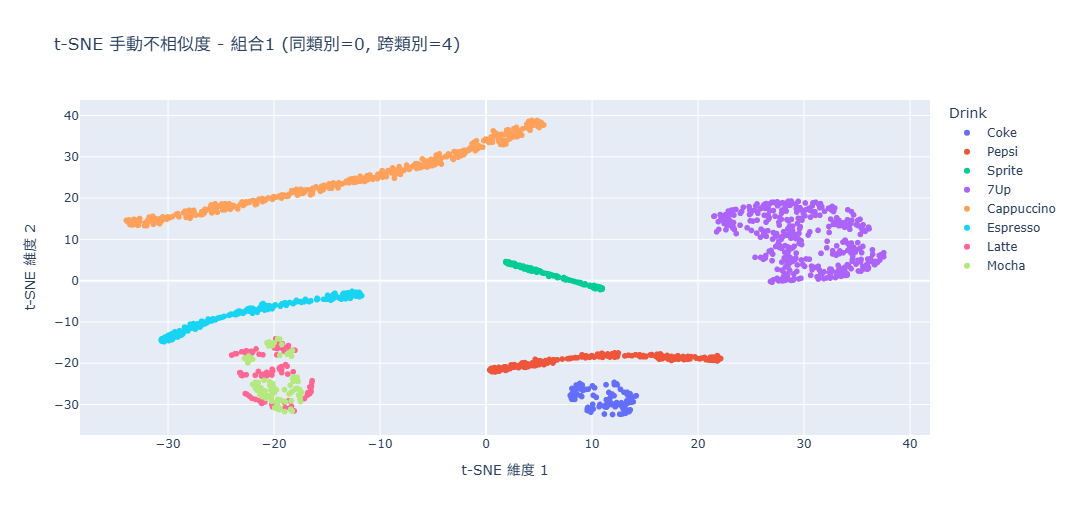

   üìä ÁµÑÂêà 2/9: ÂêåÈ°ûÂà•=0, Ë∑®È°ûÂà•=6
Â±ïÈñãË≥áÊñô...
Ë≥áÊñôÂ±ïÈñãÂÆåÊàêÔºöÂæû 8 Ë°åÂ±ïÈñãÁÇ∫ 1600 Ë°å


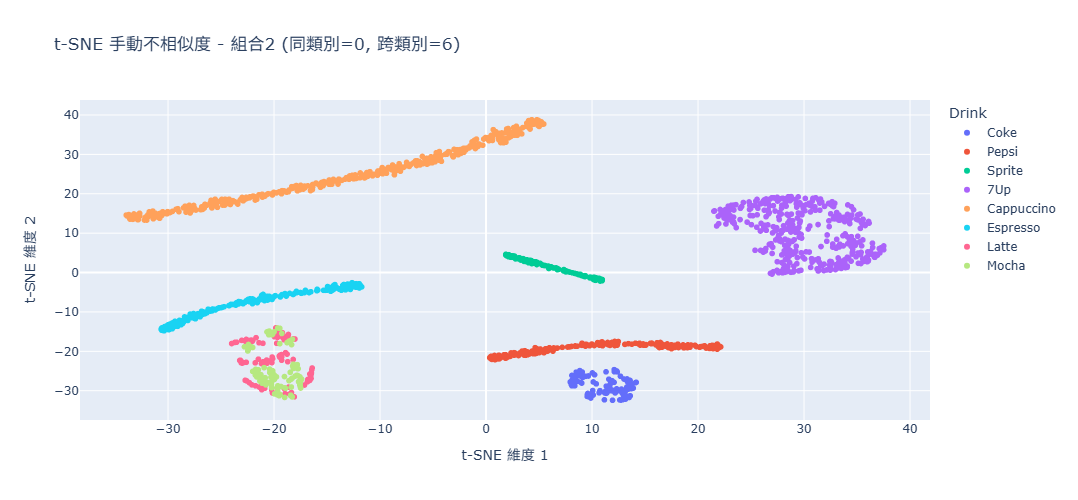

   üìä ÁµÑÂêà 3/9: ÂêåÈ°ûÂà•=0, Ë∑®È°ûÂà•=8
Â±ïÈñãË≥áÊñô...
Ë≥áÊñôÂ±ïÈñãÂÆåÊàêÔºöÂæû 8 Ë°åÂ±ïÈñãÁÇ∫ 1600 Ë°å


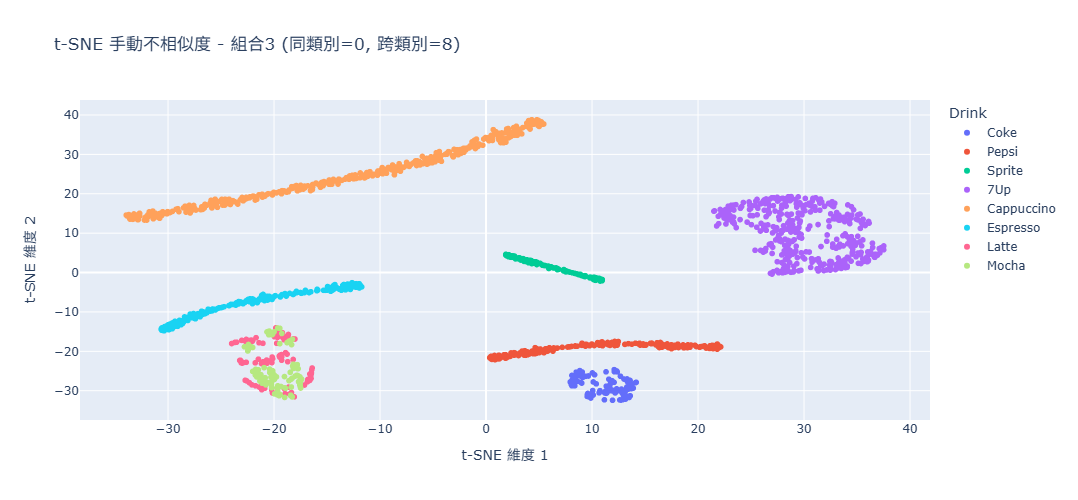

   üìä ÁµÑÂêà 4/9: ÂêåÈ°ûÂà•=1, Ë∑®È°ûÂà•=4
Â±ïÈñãË≥áÊñô...
Ë≥áÊñôÂ±ïÈñãÂÆåÊàêÔºöÂæû 8 Ë°åÂ±ïÈñãÁÇ∫ 1600 Ë°å


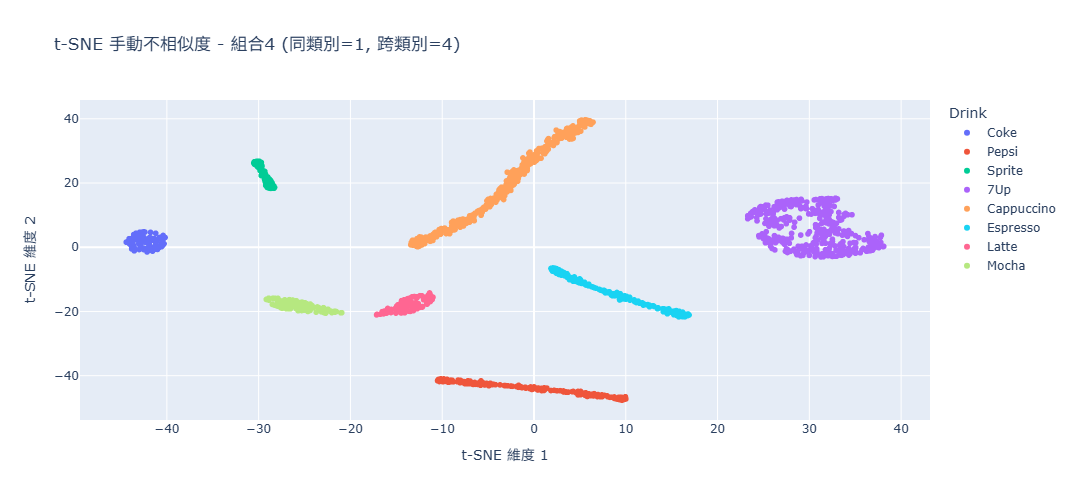

   üìä ÁµÑÂêà 5/9: ÂêåÈ°ûÂà•=1, Ë∑®È°ûÂà•=6
Â±ïÈñãË≥áÊñô...
Ë≥áÊñôÂ±ïÈñãÂÆåÊàêÔºöÂæû 8 Ë°åÂ±ïÈñãÁÇ∫ 1600 Ë°å


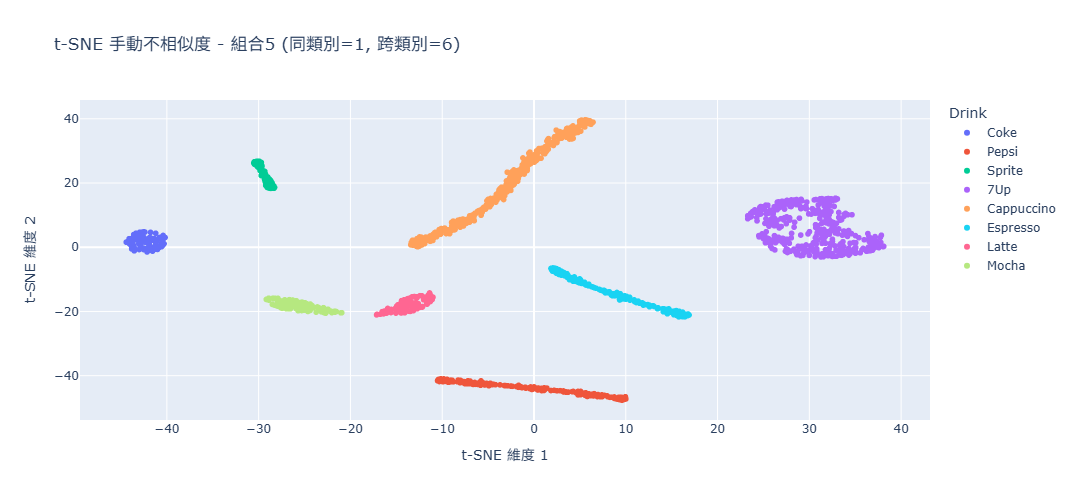

   üìä ÁµÑÂêà 6/9: ÂêåÈ°ûÂà•=1, Ë∑®È°ûÂà•=8
Â±ïÈñãË≥áÊñô...
Ë≥áÊñôÂ±ïÈñãÂÆåÊàêÔºöÂæû 8 Ë°åÂ±ïÈñãÁÇ∫ 1600 Ë°å


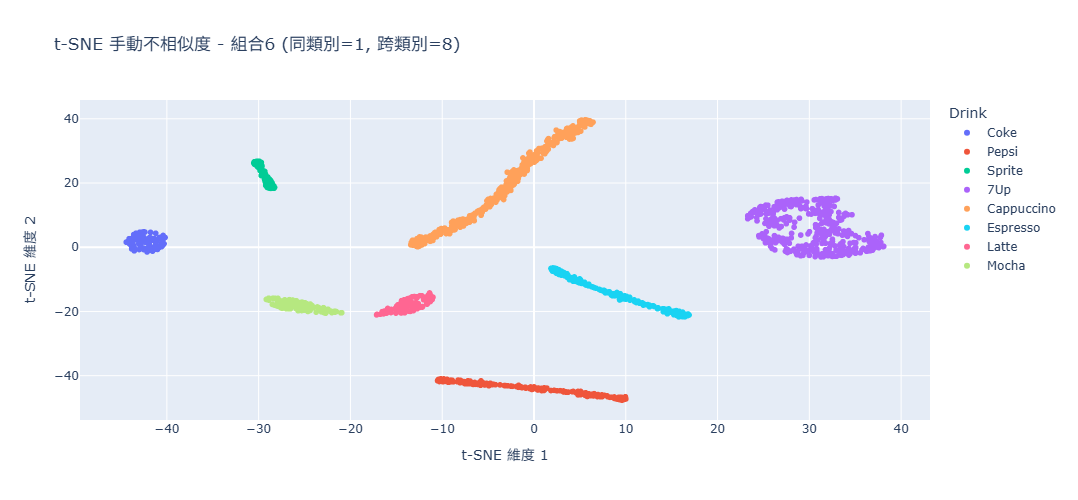

   üìä ÁµÑÂêà 7/9: ÂêåÈ°ûÂà•=2, Ë∑®È°ûÂà•=4
Â±ïÈñãË≥áÊñô...
Ë≥áÊñôÂ±ïÈñãÂÆåÊàêÔºöÂæû 8 Ë°åÂ±ïÈñãÁÇ∫ 1600 Ë°å


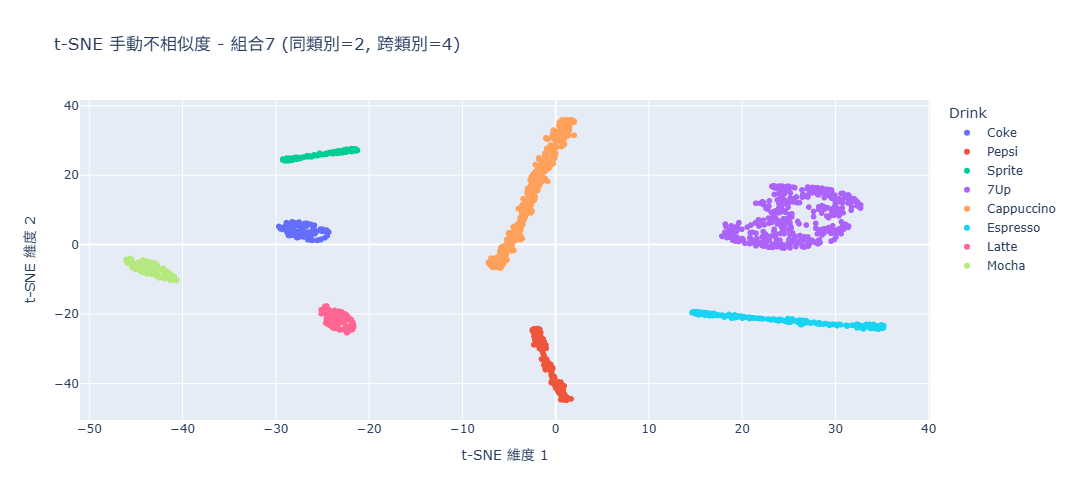

   üìä ÁµÑÂêà 8/9: ÂêåÈ°ûÂà•=2, Ë∑®È°ûÂà•=6
Â±ïÈñãË≥áÊñô...
Ë≥áÊñôÂ±ïÈñãÂÆåÊàêÔºöÂæû 8 Ë°åÂ±ïÈñãÁÇ∫ 1600 Ë°å


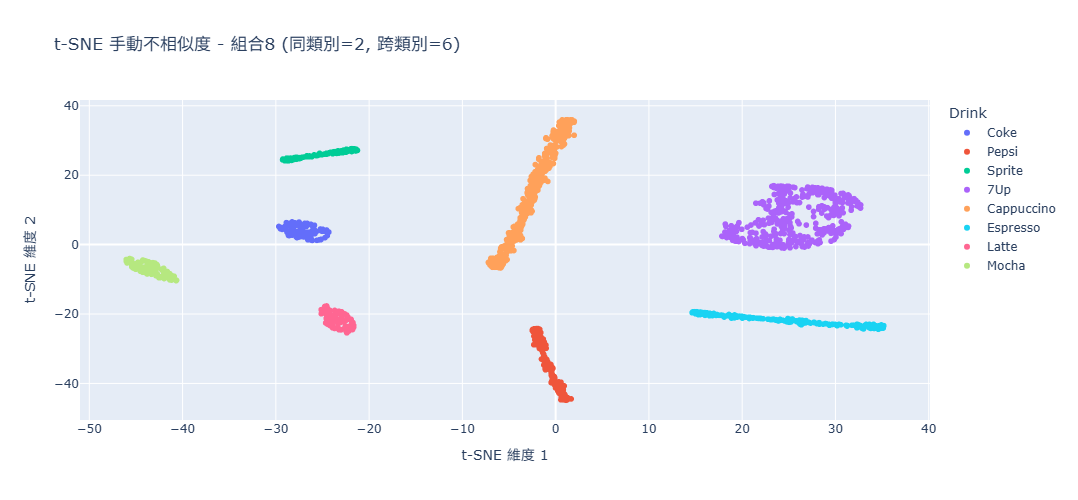

   üìä ÁµÑÂêà 9/9: ÂêåÈ°ûÂà•=2, Ë∑®È°ûÂà•=8
Â±ïÈñãË≥áÊñô...
Ë≥áÊñôÂ±ïÈñãÂÆåÊàêÔºöÂæû 8 Ë°åÂ±ïÈñãÁÇ∫ 1600 Ë°å


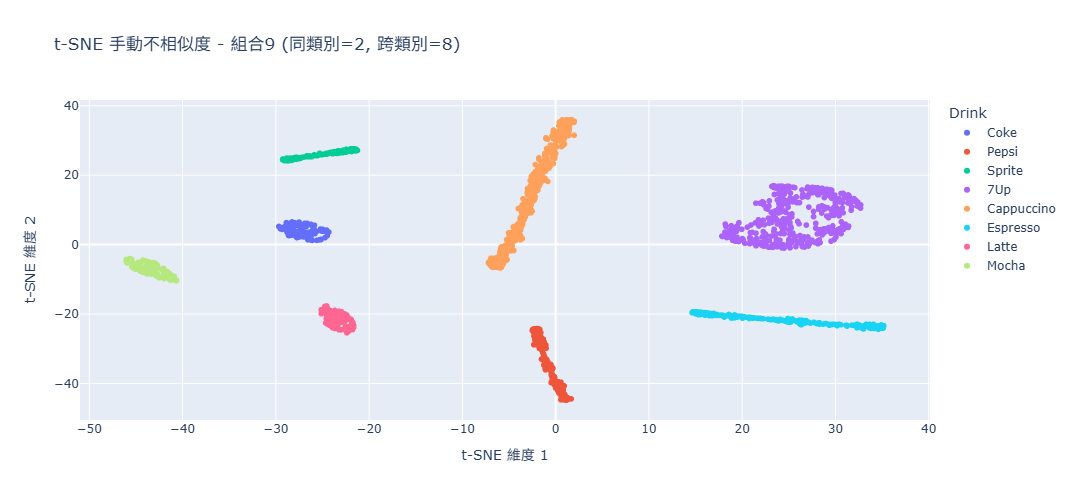

‰πùÁ®ÆÁµÑÂêàt-SNEÂÖ®ÈÉ®È°ØÁ§∫ÂÆåÊàê

ü§ñ 4. t-SNE (Word2Vec‰∏çÁõ∏‰ººÂ∫¶)...
Â±ïÈñãË≥áÊñô...
Ë≥áÊñôÂ±ïÈñãÂÆåÊàêÔºöÂæû 8 Ë°åÂ±ïÈñãÁÇ∫ 1600 Ë°å
   ‰øùÂ≠òWord2Vec t-SNEÂúñÁâáÂà∞: C:/Users/user/Desktop/ML_Work4/outputs\tsne_word2vec.png
   ‰øùÂ≠òWord2Vec t-SNEË≥áÊñôÂà∞: C:/Users/user/Desktop/ML_Work4/outputs\tsne_word2vec.csv


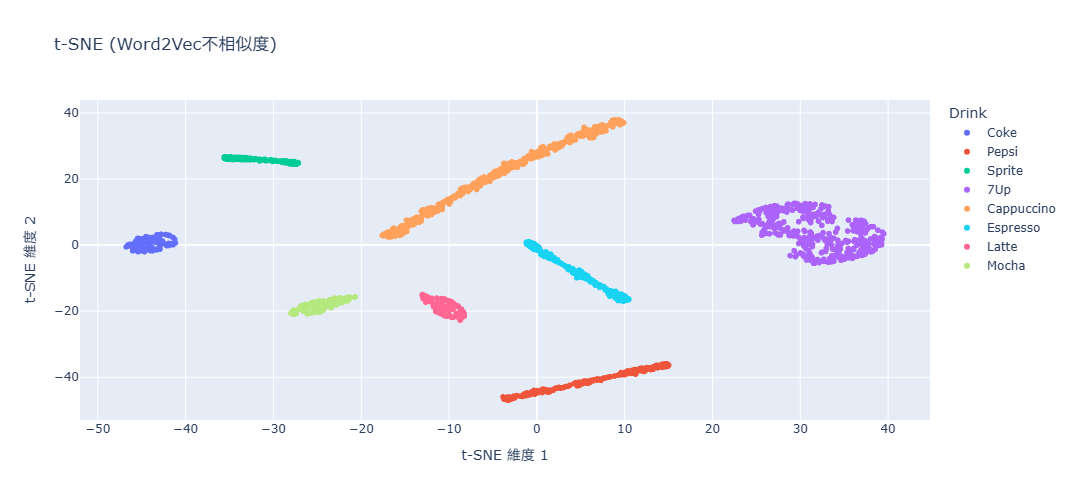

Word2Vec‰∏çÁõ∏‰ººÂ∫¶t-SNEÈ°ØÁ§∫ÂÆåÊàê

Â∑≤ÁîüÊàêÊ™îÊ°à:
 train_stations_map.html
 mds_train_stations.png
 tsne_one_hot.png
 tsne_word2vec.png
 tsne_manual_same0_cross4.png
 tsne_manual_same0_cross6.png
 tsne_manual_same0_cross8.png
 tsne_manual_same1_cross4.png
 tsne_manual_same1_cross6.png
 tsne_manual_same1_cross8.png
 tsne_manual_same2_cross4.png
 tsne_manual_same2_cross6.png
 tsne_manual_same2_cross8.png

ÊâÄÊúâ‰∫íÂãïÂºèÂúñË°®ÁîüÊàêÂÆåÊàê
Á∏ΩÂÖ±È°ØÁ§∫‰∫Ü 12 Âºµ‰∫íÂãïÂúñË°®Ôºö
 1Âºµ ÁÅ´ËªäÁ´ôMDSÂúñ
 1Âºµ One-hotÁ∑®Á¢ºt-SNEÂúñ
 9Âºµ ÊâãÂãï‰∏çÁõ∏‰ººÂ∫¶ÁµÑÂêàt-SNEÂúñ
 1Âºµ Word2Vec‰∏çÁõ∏‰ººÂ∫¶t-SNEÂúñ

‰∫íÂãïÂäüËÉΩÔºö
  ÊØèÂºµÂúñÈÉΩÊîØÊè¥ÊãñÊãâÂúàÈÅ∏Ë≥áÊñôÈªû
  Á∏ÆÊîæ„ÄÅÂπ≥Áßª„ÄÅÊá∏ÂÅúÊü•ÁúãË©≥ÊÉÖ
  ÂúàÈÅ∏ÂæåÂú®ÊéßÂà∂Âè∞È°ØÁ§∫Ë≥áÊñôÁµ±Ë®à
  ÊâÄÊúâÂúñË°®ÈÉΩÂ∑≤‰øùÂ≠òÁÇ∫PNGÂíåCSVÊ™îÊ°à

‚ú® Á®ãÂºèÂü∑Ë°åÂÆåÊàêÔºÅ


In [15]:
def main():
    """‰∏ªÁ®ãÂºè"""
    print("ÈñãÂßãÂü∑Ë°åÊ©üÂô®Â≠∏Áøí‰ΩúÊ•≠Âõõ...")
    
    # ËÆÄÂèñÈ£≤ÊñôË≥áÊñôÈõÜ
    print("ËÆÄÂèñÈ£≤ÊñôË≥áÊñôÈõÜ...")
    df = load_drink_dataset()
    if df is None:
        print("È£≤ÊñôË≥áÊñôÈõÜËºâÂÖ•Â§±Êïó")
        return
    print("È£≤ÊñôË≥áÊñôÈõÜËºâÂÖ•ÂÆåÊàê")
    
    print("\n" + "="*60)
    print("ÈñãÂßãÁîüÊàêÊâÄÊúâ‰∫íÂãïÂºèÂúñË°®")
    print("="*60)
    
    # 1. ÁÅ´ËªäÁ´ôMDSÂúñ
    print("\n1. ÁÅ´ËªäÁ´ôMDSÂúñ...")
    mds_coords, station_names = process_train_stations()
    fig_mds, mds_df = create_interactive_mds_plot(mds_coords, station_names)
    fig_mds.show()
    print("ÁÅ´ËªäÁ´ôMDSÂúñÈ°ØÁ§∫ÂÆåÊàê")
    
    # 2. One-hotÁ∑®Á¢ºt-SNE
    print("\n 2. t-SNE (One-hotÁ∑®Á¢º)...")
    tsne_onehot_data = tsne_one_hot(df)
    fig_onehot = create_interactive_tsne_plot(
        tsne_onehot_data, 
        "t-SNE (One-hotÁ∑®Á¢º)", 
        "onehot"
    )
    fig_onehot.show()
    print("One-hotÁ∑®Á¢ºt-SNEÈ°ØÁ§∫ÂÆåÊàê")
    
    # 3. ‰πùÁ®ÆÊâãÂãï‰∏çÁõ∏‰ººÂ∫¶ÁµÑÂêàt-SNE
    print("\n‚öôÔ∏è  3. ‰πùÁ®ÆÊâãÂãï‰∏çÁõ∏‰ººÂ∫¶ÁµÑÂêàt-SNE...")
    same_category_levels = [0, 1, 2]
    cross_category_levels = [4, 6, 8]
    
    combination_figures = []
    combination_data = []
    
    for row_idx, same_diss in enumerate(same_category_levels):
        for col_idx, cross_diss in enumerate(cross_category_levels):
            combination_idx = row_idx * 3 + col_idx + 1
            print(f"   üìä ÁµÑÂêà {combination_idx}/9: ÂêåÈ°ûÂà•={same_diss}, Ë∑®È°ûÂà•={cross_diss}")
            
            # Ë®àÁÆót-SNE
            tsne_manual_data = tsne_manual_combination(df, same_diss, cross_diss)
            
            # Âª∫Á´ãÂúñË°®
            title = f"t-SNE ÊâãÂãï‰∏çÁõ∏‰ººÂ∫¶ - ÁµÑÂêà{combination_idx} (ÂêåÈ°ûÂà•={same_diss}, Ë∑®È°ûÂà•={cross_diss})"
            fig_manual = create_interactive_tsne_plot(
                tsne_manual_data,
                title,
                f"manual_{same_diss}_{cross_diss}"
            )
            
            # ‰øùÂ≠òÂúñÁâá
            filename = f'tsne_manual_same{same_diss}_cross{cross_diss}'
            fig_manual.write_image(file=os.path.join(OUTPUT_DIR, f'{filename}.png'), format='png')
            tsne_manual_data.to_csv(os.path.join(OUTPUT_DIR, f'{filename}.csv'), index=False)
            
            # È°ØÁ§∫ÂúñË°®
            fig_manual.show()
            
            combination_figures.append(fig_manual)
            combination_data.append(tsne_manual_data)
    
    print("‰πùÁ®ÆÁµÑÂêàt-SNEÂÖ®ÈÉ®È°ØÁ§∫ÂÆåÊàê")
    
    # 4. Word2Vec‰∏çÁõ∏‰ººÂ∫¶t-SNE
    print("\nü§ñ 4. t-SNE (Word2Vec‰∏çÁõ∏‰ººÂ∫¶)...")
    tsne_w2v_data = tsne_word2vec(df)
    fig_w2v = create_interactive_tsne_plot(
        tsne_w2v_data, 
        "t-SNE (Word2Vec‰∏çÁõ∏‰ººÂ∫¶)", 
        "word2vec"
    )
    fig_w2v.show()
    print("Word2Vec‰∏çÁõ∏‰ººÂ∫¶t-SNEÈ°ØÁ§∫ÂÆåÊàê")
    

    
    # È°ØÁ§∫Ê™îÊ°àËº∏Âá∫Ë≥áË®ä
    print("\nÂ∑≤ÁîüÊàêÊ™îÊ°à:")
    print(" train_stations_map.html")
    print(" mds_train_stations.png")
    print(" tsne_one_hot.png")
    print(" tsne_word2vec.png")

    
    for same_diss in same_category_levels:
        for cross_diss in cross_category_levels:
            print(f" tsne_manual_same{same_diss}_cross{cross_diss}.png")
    
    print("\n" + "="*60)
    print("ÊâÄÊúâ‰∫íÂãïÂºèÂúñË°®ÁîüÊàêÂÆåÊàê")
    print("="*60)
    print("Á∏ΩÂÖ±È°ØÁ§∫‰∫Ü 12 Âºµ‰∫íÂãïÂúñË°®Ôºö")
    print(" 1Âºµ ÁÅ´ËªäÁ´ôMDSÂúñ")
    print(" 1Âºµ One-hotÁ∑®Á¢ºt-SNEÂúñ")
    print(" 9Âºµ ÊâãÂãï‰∏çÁõ∏‰ººÂ∫¶ÁµÑÂêàt-SNEÂúñ")
    print(" 1Âºµ Word2Vec‰∏çÁõ∏‰ººÂ∫¶t-SNEÂúñ")
    print("\n‰∫íÂãïÂäüËÉΩÔºö")
    print("  ÊØèÂºµÂúñÈÉΩÊîØÊè¥ÊãñÊãâÂúàÈÅ∏Ë≥áÊñôÈªû")
    print("  Á∏ÆÊîæ„ÄÅÂπ≥Áßª„ÄÅÊá∏ÂÅúÊü•ÁúãË©≥ÊÉÖ")
    print("  ÂúàÈÅ∏ÂæåÂú®ÊéßÂà∂Âè∞È°ØÁ§∫Ë≥áÊñôÁµ±Ë®à")
    print("  ÊâÄÊúâÂúñË°®ÈÉΩÂ∑≤‰øùÂ≠òÁÇ∫PNGÂíåCSVÊ™îÊ°à")
    print("\n‚ú® Á®ãÂºèÂü∑Ë°åÂÆåÊàêÔºÅ")

if __name__ == '__main__':
    main()